In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
from collections import deque, namedtuple
import random
import math
import logging
import matplotlib.pyplot as plt

In [2]:
class DQN(nn.Module):
    def __init__(self, input_size, action_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, x):
        return self.net(x)

In [3]:
class DQNFrozenLake:
    def __init__(self, grid_size = 4, gamma = 0.99, lr = 1e-3):
        self.env = gym.make("FrozenLake-v1", map_name=f"{grid_size}x{grid_size}", is_slippery=True)
        self.state_size = self.env.observation_space.n
        self.action_size = self.env.action_space.n
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.policy_net = DQN(self.state_size, self.action_size).to(self.device)
        self.target_net = DQN(self.state_size, self.action_size).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        # DQN hyperparameters
        self.memory = deque(maxlen=10000)
        self.batch_size = 64
        self.gamma = gamma
        self.epsilon_start = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 1000
        self.steps_done = 0
        self.learning_rate = lr
        self.epsilon = self.epsilon_start

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.Transition = namedtuple('Transition', 
                                   ('state', 'action', 'reward', 'next_state', 'terminated'))

    def state_to_tensor(self, state):
        state_tensor = torch.zeros(self.state_size)
        state_tensor[state] = 1
        return state_tensor.to(self.device)
    
    def select_action(self, state):
        rand_value = random.random()
        self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * \
            math.exp(-1. * self.steps_done / self.epsilon_decay)
        self.steps_done += 1
        # Exploration
        if rand_value < self.epsilon:
            return random.randrange(self.action_size)
        
        # Exploitation
        else:
            with torch.no_grad():
                state_tensor = self.state_to_tensor(state)
                q_values = self.policy_net(state_tensor)
                return q_values.argmax().item()
            
    def remember(self, state, action, reward, next_state, terminated):
        self.memory.append(self.Transition(state, action, reward, next_state, terminated))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        transitions = random.sample(self.memory, self.batch_size)
        batch = self.Transition(*zip(*transitions))

        # Recorded states of simulations
        state_batch = torch.stack([self.state_to_tensor(s) for s in batch.state])
        # Recorded actions of simulations
        action_batch = torch.tensor(batch.action, device=self.device)
        reward_batch = torch.tensor(batch.reward, device=self.device)
        next_state_batch = torch.stack([self.state_to_tensor(s) for s in batch.next_state])
        terminated_batch = torch.tensor(batch.terminated, device=self.device, dtype=torch.float)

        # Compute current Q values
        current_q_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1))

        # Compute next Q values for calulating expected Q values, based on Bellman Equation
        with torch.no_grad():
            next_q_values = self.target_net(next_state_batch).max(1)[0]
            # For terminal state, no future state, then the reward is only immediate reward
            expected_q_values = reward_batch + self.gamma * next_q_values * (1 - terminated_batch)

        # Compute loss and optimize
        loss = nn.MSELoss()(current_q_values.squeeze(), expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
    
    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def train(self, episodes = 1000, target_update = 10, record_video = False):
        rewards_history = []

        if record_video:
            env = gym.make(self.env.unwrapped.spec.id, render_mode='rgb_array',
                          map_name="4x4", is_slippery=True)
            env = gym.wrappers.RecordVideo(env, "dqn_frozen_lake_videos",
                                         episode_trigger=lambda x: x % 100 == 0)
        else:
            env = self.env
        
        for episode in range(episodes):
            state, _ = env.reset()
            total_reward = 0
            terminated = False

            while not terminated:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                terminated = terminated or truncated

                self.remember(state, action, reward, next_state, terminated)
                loss = self.replay()
                state = next_state
                total_reward += reward

            if episode % target_update == 0:
                self.update_target_network()

            rewards_history.append(total_reward)

            if episode % 100 == 0:
                avg_reward = np.mean(rewards_history[-100:])
                logging.info(f"Episode {episode}/{episodes}, Avg Reward: {avg_reward:.3f}, Epsilon: {self.epsilon:.3f}")

        env.close()
        return rewards_history
    
    def save_model(self, filename):
        torch.save({
            'policy_net_state_dict': self.policy_net.state_dict(),
            'target_net_state_dict': self.target_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, filename)


    def load_model(self, filename):
        checkpoint = torch.load(filename)
        self.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        self.target_net.load_state_dict(checkpoint['target_net_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [8]:
if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)
    agent = DQNFrozenLake()
    rewards = agent.train(episodes=5000, record_video=True)
    agent.save_model("dqn_frozen_lake.pth")


/opt/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-0.mp4



INFO:root:Episode 0/5000, Avg Reward: 0.000, Epsilon: 0.992


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-0.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-100.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-100.mp4



INFO:root:Episode 100/5000, Avg Reward: 0.040, Epsilon: 0.405


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-100.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-200.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-200.mp4



INFO:root:Episode 200/5000, Avg Reward: 0.150, Epsilon: 0.113


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-200.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-300.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-300.mp4



INFO:root:Episode 300/5000, Avg Reward: 0.160, Epsilon: 0.054


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-300.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-400.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-400.mp4



INFO:root:Episode 400/5000, Avg Reward: 0.380, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-400.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-500.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-500.mp4



INFO:root:Episode 500/5000, Avg Reward: 0.420, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-500.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-600.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-600.mp4



INFO:root:Episode 600/5000, Avg Reward: 0.540, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-600.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-700.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-700.mp4



INFO:root:Episode 700/5000, Avg Reward: 0.520, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-700.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-800.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-800.mp4



INFO:root:Episode 800/5000, Avg Reward: 0.380, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-800.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-900.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-900.mp4



INFO:root:Episode 900/5000, Avg Reward: 0.550, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-900.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1000.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1000.mp4



INFO:root:Episode 1000/5000, Avg Reward: 0.590, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1000.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1100.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1100.mp4



INFO:root:Episode 1100/5000, Avg Reward: 0.560, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1100.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1200.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1200.mp4



INFO:root:Episode 1200/5000, Avg Reward: 0.510, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1200.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1300.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1300.mp4



INFO:root:Episode 1300/5000, Avg Reward: 0.470, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1300.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1400.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1400.mp4



INFO:root:Episode 1400/5000, Avg Reward: 0.530, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1400.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1500.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1500.mp4



INFO:root:Episode 1500/5000, Avg Reward: 0.490, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1500.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1600.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1600.mp4



INFO:root:Episode 1600/5000, Avg Reward: 0.460, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1600.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1700.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1700.mp4



INFO:root:Episode 1700/5000, Avg Reward: 0.520, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1700.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1800.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1800.mp4



INFO:root:Episode 1800/5000, Avg Reward: 0.540, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1800.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1900.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1900.mp4



INFO:root:Episode 1900/5000, Avg Reward: 0.510, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-1900.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2000.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2000.mp4



INFO:root:Episode 2000/5000, Avg Reward: 0.460, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2000.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2100.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2100.mp4



INFO:root:Episode 2100/5000, Avg Reward: 0.450, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2100.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2200.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2200.mp4



INFO:root:Episode 2200/5000, Avg Reward: 0.490, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2200.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2300.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2300.mp4



INFO:root:Episode 2300/5000, Avg Reward: 0.530, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2300.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2400.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2400.mp4



INFO:root:Episode 2400/5000, Avg Reward: 0.500, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2400.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2500.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2500.mp4



INFO:root:Episode 2500/5000, Avg Reward: 0.430, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2500.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2600.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2600.mp4



INFO:root:Episode 2600/5000, Avg Reward: 0.470, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2600.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2700.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2700.mp4



INFO:root:Episode 2700/5000, Avg Reward: 0.520, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2700.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2800.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2800.mp4



INFO:root:Episode 2800/5000, Avg Reward: 0.500, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2800.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2900.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2900.mp4



INFO:root:Episode 2900/5000, Avg Reward: 0.450, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-2900.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3000.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3000.mp4



INFO:root:Episode 3000/5000, Avg Reward: 0.510, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3000.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3100.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3100.mp4



INFO:root:Episode 3100/5000, Avg Reward: 0.550, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3100.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3200.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3200.mp4



INFO:root:Episode 3200/5000, Avg Reward: 0.480, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3200.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3300.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3300.mp4



INFO:root:Episode 3300/5000, Avg Reward: 0.410, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3300.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3400.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3400.mp4



INFO:root:Episode 3400/5000, Avg Reward: 0.450, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3400.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3500.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3500.mp4



INFO:root:Episode 3500/5000, Avg Reward: 0.500, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3500.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3600.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3600.mp4



INFO:root:Episode 3600/5000, Avg Reward: 0.480, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3600.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3700.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3700.mp4



INFO:root:Episode 3700/5000, Avg Reward: 0.490, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3700.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3800.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3800.mp4



INFO:root:Episode 3800/5000, Avg Reward: 0.510, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3800.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3900.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3900.mp4



INFO:root:Episode 3900/5000, Avg Reward: 0.470, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-3900.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4000.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4000.mp4



INFO:root:Episode 4000/5000, Avg Reward: 0.500, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4000.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4100.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4100.mp4



INFO:root:Episode 4100/5000, Avg Reward: 0.430, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4100.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4200.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4200.mp4



INFO:root:Episode 4200/5000, Avg Reward: 0.510, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4200.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4300.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4300.mp4



INFO:root:Episode 4300/5000, Avg Reward: 0.540, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4300.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4400.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4400.mp4



INFO:root:Episode 4400/5000, Avg Reward: 0.590, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4400.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4500.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4500.mp4



INFO:root:Episode 4500/5000, Avg Reward: 0.560, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4500.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4600.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4600.mp4



INFO:root:Episode 4600/5000, Avg Reward: 0.490, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4600.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4700.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4700.mp4



INFO:root:Episode 4700/5000, Avg Reward: 0.500, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4700.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4800.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4800.mp4



INFO:root:Episode 4800/5000, Avg Reward: 0.550, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4800.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4900.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4900.mp4



INFO:root:Episode 4900/5000, Avg Reward: 0.580, Epsilon: 0.050


Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-4900.mp4
Moviepy - Building video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-5000.mp4.
Moviepy - Writing video /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-5000.mp4



Moviepy - Done !
Moviepy - video ready /Users/xrxr/Desktop/ssh_1/ForzenLakeDQN/dqn_frozen_lake_videos/rl-video-episode-5000.mp4


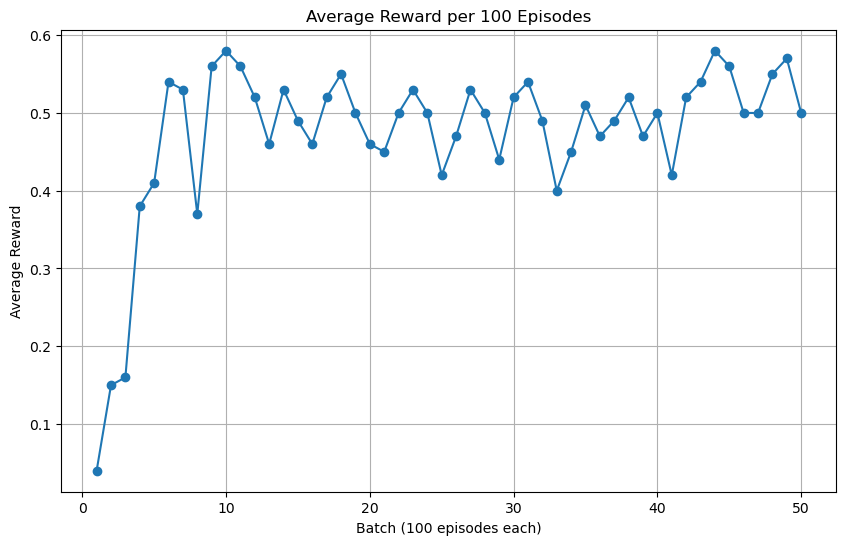

In [9]:
# Calculate the average reward for every 100 episodes
batch_size = 100
average_rewards = [np.mean(rewards[i:i + batch_size]) for i in range(0, len(rewards), batch_size)]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(average_rewards) + 1), average_rewards, marker='o')
plt.title('Average Reward per 100 Episodes')
plt.xlabel('Batch (100 episodes each)')
plt.ylabel('Average Reward')
plt.grid()
plt.show()